In [1]:
import numpy as np
from matplotlib import pyplot as plt
from util import make_rotation_matrix
import tensorflow as tf
%matplotlib inline

##Load data

In [2]:
# load images, from which the image coordinates were picked
# 4-dimensional tensor: (image,ydim,xdim,color)
images = np.load("images.npy") # 4 dime

# load image coordinates, picked by hand
# 3-dimensional tensor (image,object class,spatial dim)
# for example the imagecoords[0][1] would return the (x,y) coordiante
# of 1st object from the 0th image.
imagecoords = np.load("imagecoords.npy")

# load mask of objects not visible in the images
# same dimensions as imagecoords
observed_mask = np.load("observed_mask.npy")

# useful things
aspect_ratio = 2688.0/1520.0 #dimensions of the original images
objclass_colors = ("red","green","blue","yellow","orange","purple")

##Visualize raw data

/Library/Python/2.7/site-packages/matplotlib-override/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


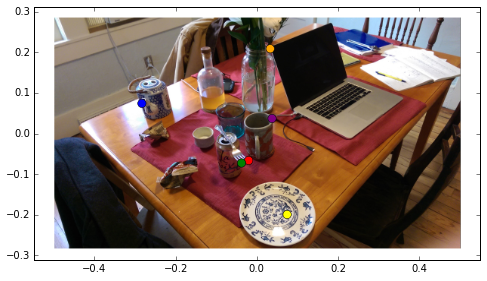

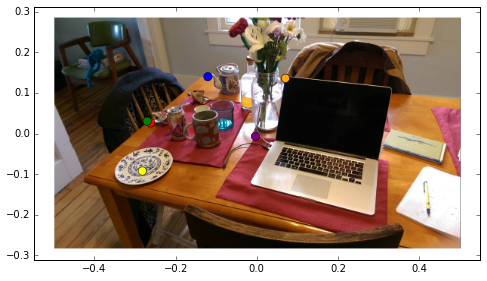

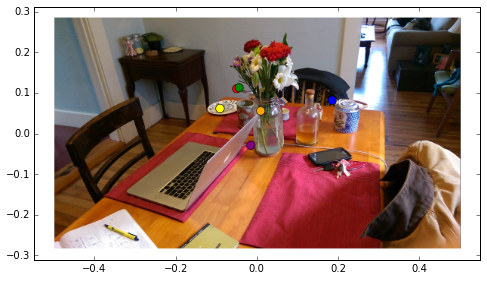

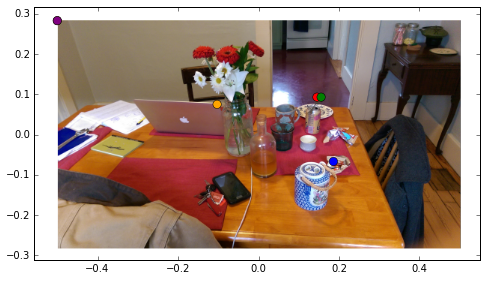

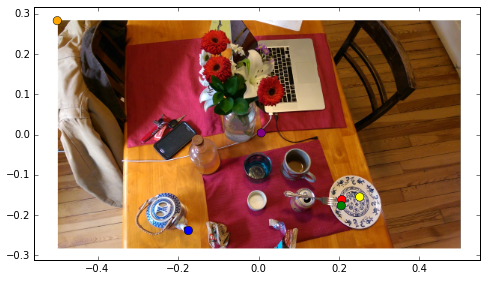

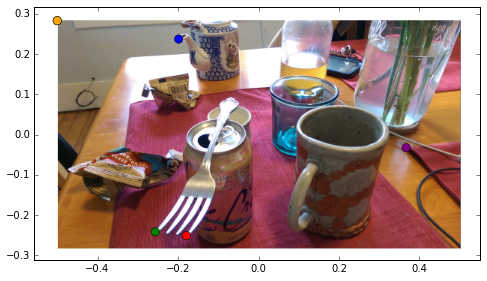

In [3]:
# display every image, along with image coordinates of objects to be located
for image, imagecoord in zip( images, imagecoords ):
    plt.figure(figsize=(8,6))
    plt.imshow( image, extent=(-0.5,0.5,-0.5/aspect_ratio,0.5/aspect_ratio) )
    plt.scatter(*imagecoord.T, c=objclass_colors, s=70,lw=0.5)
    plt.show()

##Make a rough guess about camera and object locations

In [4]:
# make a rough guess about the camera positions and orientations

camera_pos = np.array([[150,100,50],
              [150,100,-100],
              [-20,150,-400],
              [-150,100,-50],
              [0,200,30],
              [100,50,-10]],dtype=np.float32) # rough guess
camera_orientation = np.array([[0,45,0],
                      [0,100,0],
                      [0,-170,0],
                      [0,-90,0],
                      [-90,0,0],
                      [0,90,0]],dtype=np.float32) # rough guess; note, in degrees

camera_orientation = np.pi * camera_orientation/180 #convert to radians

In [5]:
# make a rough guess about the object positions

obj_pos = np.array( [[75,20,-50],
             [75,20,-45],
             [-65,20,-45],
             [85,5,-50],
             [10,30,-100],
             [10,0,-100]],dtype=np.float32 )

# obj_pos = np.array( [[0,0,0],
#              [0,0,0],
#              [0,0,0],
#              [0,0,0],
#              [0,0,0],
#              [0,0,0]],dtype=np.float32 )

##Visualize initial guess for cameras and objects

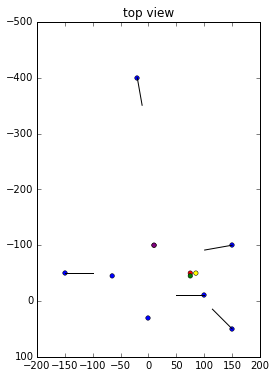

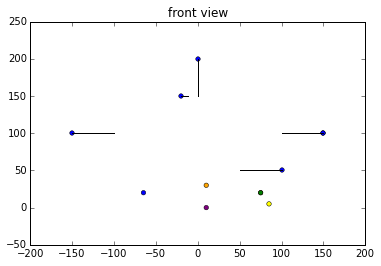

In [6]:

look_normals = []
for alpha,beta,gamma in camera_orientation:
    A = make_rotation_matrix( -alpha,-beta,-gamma )
    looky = [0,0,-50]
    look_normals.append( np.dot(np.linalg.inv(A),looky) )
look_normals = np.array(look_normals)
look_endpoints = camera_pos+look_normals

# looking at the whole scene from the top
cx,cz = camera_pos.T[[0,2]]
px,pz = obj_pos.T[[0,2]]
plt.figure(figsize=(4,6))
plt.xlim(-200,200)
plt.ylim(-500,100)
plt.gca().invert_yaxis()
plt.scatter(cx,cz,c="blue",lw=0.5)
plt.scatter(px,pz,c=objclass_colors,lw=0.5)
plt.title("top view")

for i in range(6):
    cx,cy,cz = camera_pos[i]
    lx,ly,lz = look_endpoints[i]
    
    plt.plot([cx,lx],[cz,lz],c="black")
plt.show()

# looking at the whole scene from the front
cx,cz = camera_pos.T[[0,1]]
px,pz = obj_pos.T[[0,1]]
# plt.figure(figsize=(4,6))
# plt.xlim(-200,200)
# plt.ylim(-500,100)
plt.scatter(cx,cz,c="blue",lw=0.5)
plt.scatter(px,pz,c=("red","green","blue","yellow","orange","purple"),lw=0.5)
plt.title("front view")

for i in range(6):
    cx,cy,cz = camera_pos[i]
    lx,ly,lz = look_endpoints[i]
    
    plt.plot([cx,lx],[cy,ly],c="black")
plt.show()

##Set up Tensorflow graph

In [8]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

nimages,nobjclasses,_=imagecoords.shape

# camera orientation variables
homo_camera_pos = np.hstack( (camera_pos, np.ones( (nimages,1) )) )
tfcam_pos = tf.Variable(np.array(camera_pos,dtype=np.float32)*0.001) #scale camera position
tfcam_orient = tf.Variable(camera_orientation)

# object positions
homo_obj_pos = np.hstack( (obj_pos*0.001, np.ones( (nobjclasses,1) )) ).astype(np.float32)
tfobj_pos = tf.Variable( homo_obj_pos )

# image coordinates
# transpose the dimensions from (image,object class,spatial dim) to (image,spatial dim,object_class)
tfimagecoords = tf.transpose( tf.cast( tf.constant(imagecoords), tf.float32 ), (0,2,1) )

# observed points mask
# transpose the dimensions from (image,object class,spatial dim) to (image,spatial dim,object_class)
tfobserved_mask = tf.cast( tf.transpose( tf.constant(observed_mask), (0,2,1) ), tf.float32 )

# focal length!
focal_length = tf.Variable(0.8)

# take an [n,3] stack of num_images euler angle orientation and return
# [n,3,3] stack of rotation matrices
def tfmake_rotation_matrix(theta):
    a = theta[:,0]
    b = theta[:,1]
    c = theta[:,2]
    
    ncameras = tf.shape(a)
    
    zero = tf.zeros(ncameras)
    one = tf.ones(ncameras)
    
    A_x = tf.reshape( 
           tf.transpose( 
             tf.pack([one,zero,zero,zero,
                      zero,tf.cos(a),-tf.sin(a),zero,
                      zero,tf.sin(a),tf.cos(a),zero,
                      zero,zero,zero,one]) 
           ),
           (nimages,4,4)
         )
    
    A_y = tf.reshape( 
           tf.transpose( 
             tf.pack([tf.cos(b),zero,tf.sin(b),zero,
                      zero,one,zero,zero,
                      -tf.sin(b),zero,tf.cos(b),zero,
                      zero,zero,zero,one]) 
           ),
           (nimages,4,4)
         )
    
    A_z = tf.reshape( 
           tf.transpose( 
             tf.pack([tf.cos(c),-tf.sin(c),zero,zero,
                      tf.sin(c),tf.cos(c),zero,zero,
                      zero,zero,one,zero,
                      zero,zero,zero,one]) 
           ),
           (nimages,4,4)
         )
    
    A = tf.batch_matmul(tf.batch_matmul(A_x,A_y),A_z)
    
    return A

def tfmake_translation_matrix(pos):
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]
    
    ncameras = tf.shape(x)
    
    zero = tf.zeros(ncameras)
    one = tf.ones(ncameras)
    
    A = tf.reshape( 
           tf.transpose( 
             tf.pack([one,zero,zero,x,
                      zero,one,zero,y,
                      zero,zero,one,z,
                      zero,zero,zero,one]) 
           ),
           (nimages,4,4)
         )
    
    return A

def tfmake_perp_proj_matrix(focal_length):    
    A = tf.reshape( 
           tf.transpose( 
             tf.pack([1,0,0,0,
                      0,1,0,0,
                      0,0,1,0,
                      0,0,-1/focal_length,0]) 
           ),
           (4,4)
         )
    
    return A

tfrotation_operator = tfmake_rotation_matrix(-tfcam_orient)
tftranslation_operator = tfmake_translation_matrix(-tfcam_pos)
tftransform_operator = tf.batch_matmul(tfrotation_operator,tftranslation_operator)

# #points in camera reference frame
# Explicitly broadcast the object position matrix into a stack of 
# nimages identical matrices, so that we can use batch_matmul.
# In the future, batch_matmul will probably do the broadcasting automatically
tfbroadcast_pos = tf.reshape( tf.tile( tf.transpose( tfobj_pos ), (nimages,1) ), (nimages,4,nobjclasses))
tfcam_transform_pts = tf.batch_matmul(tftransform_operator, tfbroadcast_pos)

# points projected into perspective
# we could use a projection matrix but this is actually pretty simple
depth = tf.reshape( tfcam_transform_pts[:,2,:], (nimages,1,nobjclasses) )
bigness = focal_length/-depth
tfprojpoint = (tfcam_transform_pts*bigness)[:,0:2,:]

# find the loss
residuals = tfobserved_mask*(tfprojpoint - tfimagecoords)
loss = tf.reduce_mean( tf.square( residuals ) )

# set up the optimizer
opt = tf.train.AdagradOptimizer(learning_rate=0.1)
opt_op = opt.minimize(loss, var_list=(tfcam_orient,tfcam_pos,tfobj_pos,focal_length))

init_op = tf.initialize_all_variables()

In [10]:
with tf.Session() as sess:
    
    sess.run(init_op)
    
    print sess.run(loss)
    print sess.run(residuals)

0.184609
[[[ 0.13437507  0.13169208 -0.02656728  0.09492022 -0.00552388 -0.00998817]
  [-0.45097786 -0.45986515 -0.36637139 -0.45199054 -0.48216689 -0.42733026]]

 [[-0.08947733 -0.12449363  0.0596907  -0.13567758  0.07037707  0.14440981]
  [-0.80176723 -0.79778874 -0.42947364 -0.9532032  -0.54233134 -0.57354736]]

 [[-0.02312707 -0.02620565  0.06200168 -0.0031938   0.05033104  0.07451259]
  [-0.39843673 -0.39716804 -0.38612336 -0.38138935 -0.37510988 -0.37048703]]

 [[-0.14508933 -0.13772821 -0.13895313  0.         -0.14694944  0.        ]
  [-0.37745041 -0.37745041 -0.68597692 -0.         -0.42514879 -0.        ]]

 [[ 0.12648807  0.12760414 -0.11440973  0.09722987  0.          0.03330357]
  [ 0.51738596  0.51004469  0.57180065  0.48333913  0.          0.51590776]]

 [[ 1.45931554  1.37632465  0.36835772  0.          0.          0.43318459]
  [-0.708884   -0.71818459 -0.38280571 -0.         -0.         -0.41170639]]]


##Solve camera and object locations using gradient descent

In [11]:
init_op = tf.initialize_all_variables()

# Launch the graph in a session.
with tf.Session() as sess:
    
    sess.run(init_op)
    
    for i in range(10000):
        sess.run( opt_op )
        if i%500==0:
            print i, sess.run( loss )
            
    solved_cam_pos = sess.run( tfcam_pos )/0.001
    solved_cam_orient = sess.run( tfcam_orient )
    solved_obj_pos = sess.run( tfobj_pos )/0.001
    solved_focal_length = sess.run( focal_length )
    
    residual_observations = sess.run( tfprojpoint )


0 0.0796362
500 0.000915663
1000 0.000331134
1500 0.000204738
2000 0.000148263
2500 0.000115126
3000 9.291e-05
3500 7.69181e-05
4000 6.49263e-05
4500 5.56892e-05
5000 4.8425e-05
5500 4.26129e-05
6000 3.78916e-05
6500 3.40057e-05
7000 3.07707e-05
7500 2.805e-05
8000 2.57409e-05
8500 2.37646e-05
9000 2.20599e-05
9500 2.05785e-05


##Visualize solved positions for cameras and objects

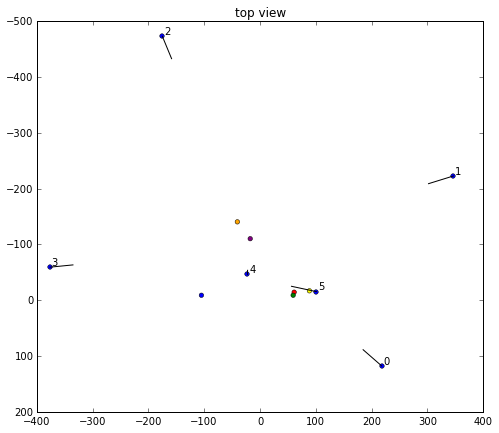

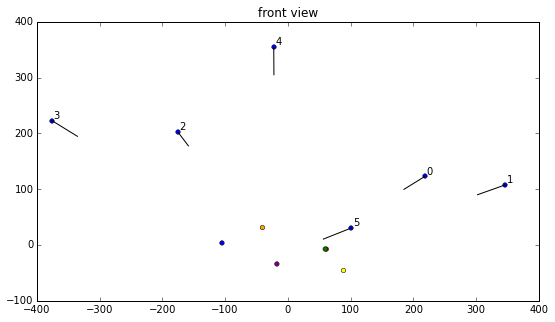

In [12]:
look_normals = []
for alpha,beta,gamma in solved_cam_orient:
    A = make_rotation_matrix( -alpha,-beta,-gamma )
    looky = [0,0,-50]
    look_normals.append( np.dot(np.linalg.inv(A),looky) )
look_normals = np.array(look_normals)
look_endpoints = solved_cam_pos+look_normals

# looking at the whole scene from the top
cx,cz = solved_cam_pos.T[[0,2]]
px,pz = solved_obj_pos.T[[0,2]]
plt.figure(figsize=(8,7))
plt.xlim(-400,400)
plt.ylim(-500,200)
plt.gca().invert_yaxis()
plt.scatter(cx,cz,c="blue",lw=0.5)
plt.scatter(px,pz,c=objclass_colors,lw=0.5)
plt.title("top view")

for i in range(6):
    cx,cy,cz = solved_cam_pos[i]
    lx,ly,lz = look_endpoints[i]
    
    plt.plot([cx,lx],[cz,lz],c="black")
    plt.text(cx+4,cz-4,str(i))
plt.show()

# looking at the whole scene from the front
cx,cz = solved_cam_pos.T[[0,1]]
px,pz = solved_obj_pos.T[[0,1]]
plt.figure(figsize=(9,5))
plt.xlim(-400,400)
plt.ylim(-100,400)
plt.scatter(cx,cz,c="blue",lw=0.5)
plt.scatter(px,pz,c=("red","green","blue","yellow","orange","purple"),lw=0.5)
plt.title("front view")

for i in range(6):
    cx,cy,cz = solved_cam_pos[i]
    lx,ly,lz = look_endpoints[i]
    
    plt.plot([cx,lx],[cy,ly],c="black")
    plt.text(cx+4,cy+4,str(i))
plt.show()

##Visualize image coordinates compared to solved object coordinates projected to solved camera locations

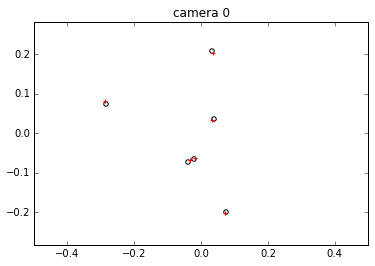

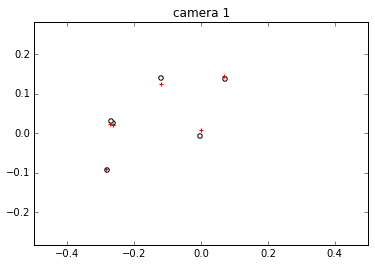

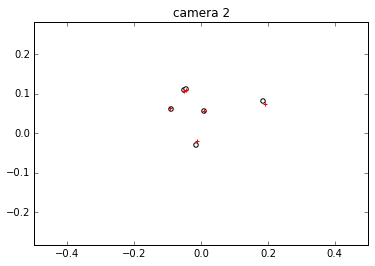

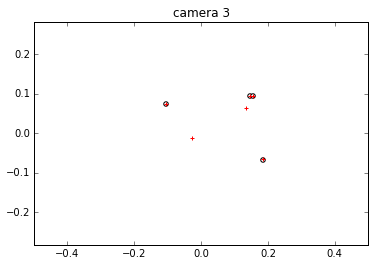

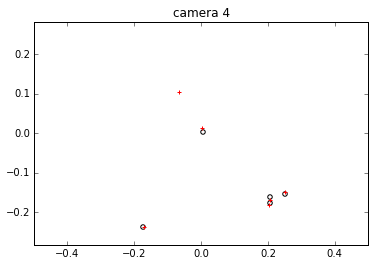

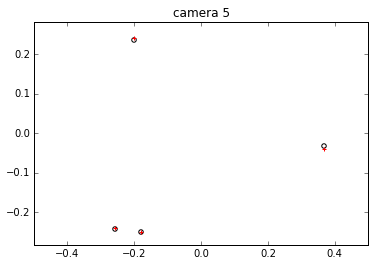

In [13]:
for i in range(6):
    plt.xlim(-0.5,0.5)
    plt.ylim( -0.5/aspect_ratio,0.5/aspect_ratio )
    plt.scatter( *imagecoords[i].T, c="white" )
    plt.scatter( *residual_observations[i], marker="+", c="red" )
    plt.title("camera %d"%i)
    plt.show()


In [28]:
from theano import tensor as T
import theano as th
from theano import gradient

# # camera orientation variables
# homo_camera_pos = np.hstack( (camera_pos, np.ones( (nimages,1) )) )
# tfcam_pos = tf.Variable(np.array(camera_pos,dtype=np.float32)*0.001) #scale camera position
# tfcam_orient = tf.Variable(camera_orientation)

cam_pos = T.fmatrix('cam_pos')

# scale camera position
scaled_cam_pos = cam_pos*1.0

# pad the matrix with ones to make it into homogeneous coordinates
ncams = T.shape(cam_pos)[0]
ones_col = T.alloc(1,ncams,1)
homo_cam_pos = T.concatenate([scaled_cam_pos,ones_col],axis=1)

thcam_orient = T.fmatrix('cam_orient')

# object positions
tfobj_pos = T.fmatrix('obj_pos')

# scale object posiion
scaled_obj_pos = tfobj_pos*1.0

# turn object positions into homogeneous coordinates
nobjs = T.shape(tfobj_pos)[0]
ones_col = T.alloc(1,nobjs,1)
homo_obj_pos = T.concatenate([scaled_obj_pos,ones_col],axis=1)

# image coordinates
# transpose the dimensions from (image,object class,spatial dim) to (image,spatial dim,object_class)
thimagecoords = T.ftensor3('imagecoords')
thsideways_imagecoords = thimagecoords.dimshuffle(0,2,1)

# observed points mask
# transpose the dimensions from (image,object class,spatial dim) to (image,spatial dim,object_class)
#tfobserved_mask = tf.cast( tf.transpose( tf.constant(observed_mask), (0,2,1) ), tf.float32 )
thobserved_mask = T.ftensor3('observed_mask')
thsideways_observed_mask = thobserved_mask.dimshuffle(0,2,1)

# focal length!
thfocal_length = T.fscalar('focal_length')

# take an [n,3] stack of num_images euler angle orientation and return
# [n,3,3] stack of rotation matrices
def thmake_rotation_matrix(theta):
    a = theta[:,0]
    b = theta[:,1]
    c = theta[:,2]
    
    ncameras = theta.shape[0]
    
    zero = T.zeros_like(a)
    one = T.ones_like(a)
    
    A_x = T.stacklists([[one,zero,zero,zero],
                        [zero,T.cos(a),-T.sin(a),zero],
                        [zero,T.sin(a),T.cos(a),zero],
                        [zero,zero,zero,one]]).dimshuffle(2,0,1)
    
    A_y = T.stacklists([[T.cos(b),zero,T.sin(b),zero],
                        [zero,one,zero,zero],
                        [-T.sin(b),zero,T.cos(b),zero],
                        [zero,zero,zero,one]]).dimshuffle(2,0,1)
    
    A_z = T.stacklists([[T.cos(c),-T.sin(c),zero,zero],
                        [T.sin(c),T.cos(c),zero,zero],
                        [zero,zero,one,zero],
                        [zero,zero,zero,one]]).dimshuffle(2,0,1)
    
    A = T.batched_dot(T.batched_dot(A_x,A_y),A_z)
    
    return A

def thmake_translation_matrix(pos):
    x = pos[:,0]
    y = pos[:,1]
    z = pos[:,2]
    
    zero = T.zeros_like(x)
    one = T.ones_like(x)
    
    A = T.stacklists([[one,zero,zero,x],
                      [zero,one,zero,y],
                      [zero,zero,one,z],
                      [zero,zero,zero,one]]).dimshuffle(2,0,1)
    
    return A

rotation_operators = thmake_rotation_matrix(-thcam_orient)
translation_operators = thmake_translation_matrix(-homo_cam_pos)
transform_operators = T.batched_dot(rotation_operators,translation_operators)

#points in camera reference frame
thbroadcast_pos = T.shape_padleft( homo_obj_pos.transpose(), 1 ).repeat(ncams,axis=0)
thcam_transform_pts = T.batched_dot(transform_operators,thbroadcast_pos)

# points projected into perspective
# we could use a projection matrix but this is actually pretty simple
thdepth = T.shape_padleft(thcam_transform_pts[:,2,:]).dimshuffle(1,0,2)
thbigness = thfocal_length/-thdepth
thprojpoint = (thcam_transform_pts*thbigness)[:,0:2,:]

# find the loss
thresiduals = thsideways_observed_mask*(thprojpoint - thsideways_imagecoords)
thloss = T.square( thresiduals ).mean()

gg = gradient.grad(thloss,
                   [cam_pos,thcam_orient,tfobj_pos], 
                   consider_constant=[thfocal_length,thimagecoords,thobserved_mask])

In [29]:
f = th.function([cam_pos,thcam_orient,tfobj_pos,thfocal_length,thimagecoords,thobserved_mask],thloss)
fresiduals = th.function([cam_pos,thcam_orient,tfobj_pos,thfocal_length,thimagecoords,thobserved_mask],thresiduals)
gf = th.function([cam_pos,thcam_orient,tfobj_pos,thfocal_length,thimagecoords,thobserved_mask],gg)

In [30]:
print f(camera_pos,camera_orientation,obj_pos,0.8,imagecoords.astype(np.float32),observed_mask.astype(np.float32))
print fresiduals(camera_pos,camera_orientation,obj_pos,0.8,imagecoords.astype(np.float32),observed_mask.astype(np.float32))

0.184608757496
[[[ 0.13437502  0.13169205 -0.02656734  0.09492016 -0.00552391 -0.0099882 ]
  [-0.45097792 -0.45986515 -0.36637145 -0.45199054 -0.48216689 -0.42733026]]

 [[-0.08947733 -0.12449372  0.05969068 -0.13567764  0.07037707  0.14440981]
  [-0.80176723 -0.79778874 -0.42947367 -0.9532032  -0.54233134 -0.57354736]]

 [[-0.02312707 -0.02620563  0.06200166 -0.00319379  0.05033104  0.07451259]
  [-0.3984367  -0.39716804 -0.38612336 -0.38138935 -0.37510985 -0.37048703]]

 [[-0.14508933 -0.13772821 -0.13895312  0.         -0.14694947  0.        ]
  [-0.37745041 -0.37745041 -0.68597692 -0.         -0.42514879 -0.        ]]

 [[ 0.1264881   0.12760417 -0.11440973  0.09722987  0.          0.03330357]
  [ 0.51738596  0.51004469  0.57180065  0.4833391   0.          0.51590782]]

 [[ 1.45931542  1.37632442  0.36835772  0.          0.          0.43318465]
  [-0.70888388 -0.71818447 -0.38280573 -0.         -0.         -0.41170639]]]


In [52]:
xcampos = camera_pos.copy()*0.001
xcamorient = camera_orientation.copy()
xobjpos = obj_pos.copy()*0.001

for i in range(40000):
    if i%500==0:
        print i, f(xcampos,xcamorient,xobjpos,0.8,imagecoords.astype(np.float32),observed_mask.astype(np.float32))
    dcampos,dcamorient,dobjpos = gf(xcampos,xcamorient,xobjpos,0.8,imagecoords.astype(np.float32),observed_mask.astype(np.float32))

    alpha = 0.03
    xcampos -= dcampos*alpha
    xcamorient -= dcamorient*alpha
    xobjpos -= dobjpos*alpha

print f(xcampos,xcamorient,xobjpos,0.8,imagecoords.astype(np.float32),observed_mask.astype(np.float32))

0 0.184608772397
500 0.00165594031569
1000 0.00136298139114
1500 0.00121985434089
2000 0.00110162806232
2500 0.000993896508589
3000 0.00089370115893
3500 0.000801246322226
4000 0.00071777246194
4500 0.000644453975838
5000 0.000581790751312
5500 0.00052935135318
6000 0.00048596446868
6500 0.000450110645033
7000 0.000420283729909
7500 0.000395148963435
8000 0.00037365348544
8500 0.000354963209247
9000 0.00033844972495
9500 0.000323667394696
10000 0.00031026857323
10500 0.000297992199194
11000 0.000286643247819
11500 0.000276068691164
12000 0.0002661680046
12500 0.000256843486568
13000 0.000248029653449
13500 0.000239677901845
14000 0.000231746977079
14500 0.000224191011512
15000 0.000216977918171
15500 0.000210088895983
16000 0.000203497998882
16500 0.000197187182494
17000 0.000191142069525
17500 0.000185347802471
18000 0.000179780312465
18500 0.000174444910954
19000 0.000169316015672
19500 0.00016438314924
20000 0.00015965050261
20500 0.000155095694936
21000 0.000150715568452
21500 0.00

In [53]:
solved_cam_pos = xcampos/0.001
solved_cam_orient = xcamorient
solved_obj_pos = xobjpos/0.001

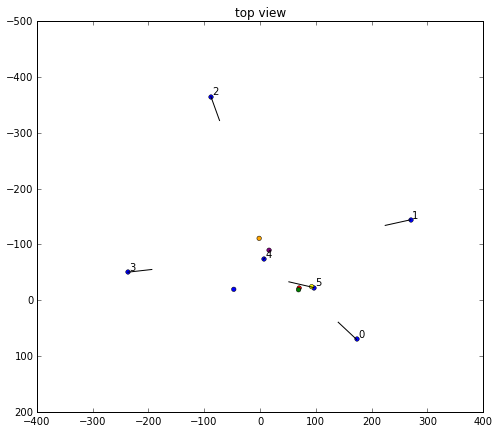

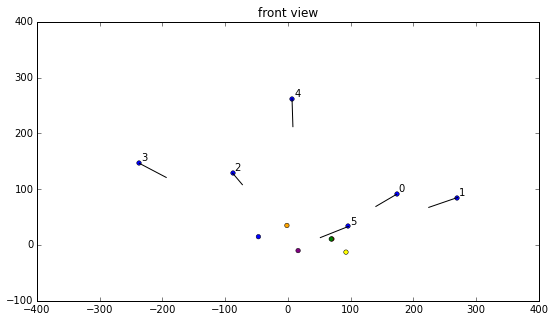

In [54]:
look_normals = []
for alpha,beta,gamma in solved_cam_orient:
    A = make_rotation_matrix( -alpha,-beta,-gamma )
    looky = [0,0,-50]
    look_normals.append( np.dot(np.linalg.inv(A),looky) )
look_normals = np.array(look_normals)
look_endpoints = solved_cam_pos+look_normals

# looking at the whole scene from the top
cx,cz = solved_cam_pos.T[[0,2]]
px,pz = solved_obj_pos.T[[0,2]]
plt.figure(figsize=(8,7))
plt.xlim(-400,400)
plt.ylim(-500,200)
plt.gca().invert_yaxis()
plt.scatter(cx,cz,c="blue",lw=0.5)
plt.scatter(px,pz,c=objclass_colors,lw=0.5)
plt.title("top view")

for i in range(6):
    cx,cy,cz = solved_cam_pos[i]
    lx,ly,lz = look_endpoints[i]
    
    plt.plot([cx,lx],[cz,lz],c="black")
    plt.text(cx+4,cz-4,str(i))
plt.show()

# looking at the whole scene from the front
cx,cz = solved_cam_pos.T[[0,1]]
px,pz = solved_obj_pos.T[[0,1]]
plt.figure(figsize=(9,5))
plt.xlim(-400,400)
plt.ylim(-100,400)
plt.scatter(cx,cz,c="blue",lw=0.5)
plt.scatter(px,pz,c=("red","green","blue","yellow","orange","purple"),lw=0.5)
plt.title("front view")

for i in range(6):
    cx,cy,cz = solved_cam_pos[i]
    lx,ly,lz = look_endpoints[i]
    
    plt.plot([cx,lx],[cy,ly],c="black")
    plt.text(cx+4,cy+4,str(i))
plt.show()